## Part 0: Load Data

Set the variable `CENSUS_FILE` to the **full path** to the census dataset (**census_dataset.csv**) on your system. Load the file into a dataframe (you may intialize the column names using the header list `census_column_names`), then:
1. Determine the number and types of features.
2. Determine the number of classes and their prevalence in the dataset. Are the classes balanced?
3. Perform any necessary preprocessing on dataset.
4. Perform a **stratified split** of the data into training/validation/test sets, 60%/20%/20%. 
5. Verify that the training/validation/test splits have the same prevalence as the original dataset.
6. Standardize the training/validation/test splits (fit on the training, then transform the validation/test sets). Use the standardized splits for the SVM models *only*.

In [1]:
census_column_names=['age','workclass','fnlwgt','education','education-num',
                      'marital-status','occupation','relationship','race','sex',
                      'capital-gain','capital-loss','hours-per-week','native-country',
                      'annual-income']

In [2]:
#load the dataset
import pandas as pd
import numpy as np
import os

#CENSUS_FILE = <full path to dataset>
census_data=pd.read_csv("census_dataset.csv",names=census_column_names)
census_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,annual-income
0,73,Unknown,378922,HS-grad,9,Married-spouse-absent,Unknown,Not-in-family,White,Female,0,0,20,Canada,<=50K
1,46,Private,207807,10th,6,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,30,United-States,<=50K
2,55,Self-emp-not-inc,319733,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
3,38,Unknown,365465,Assoc-voc,11,Never-married,Unknown,Own-child,White,Male,0,0,15,United-States,<=50K
4,26,Self-emp-not-inc,33016,Assoc-voc,11,Divorced,Other-service,Unmarried,White,Female,0,0,55,United-States,<=50K


1. Determine the number and types of features.

In [3]:
#Determine number of features, one less that the total number of columns as annual-income is the label
num_features=len(census_data.columns)-1
print("Number of features:",num_features)

Number of features: 14


In [4]:
#Determine nature of object types
census_cat_columns=dict()
census_cat_columns_idx=dict()
census_num_columns_idx=dict()
for col in census_column_names:
    if census_data[col].dtype == 'object':
        census_cat_columns[col]=census_data[col].unique()
        census_cat_columns_idx[col]=census_data.columns.get_loc(col)
        print(col,":",census_cat_columns[col])
    elif np.issubdtype(census_data.at[0,col], np.number):
        census_num_columns_idx[col]=census_data.columns.get_loc(col)

workclass : ['Unknown' 'Private' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Local-gov' 'Never-worked' 'Without-pay']
education : ['HS-grad' '10th' 'Assoc-voc' 'Assoc-acdm' 'Bachelors' 'Prof-school'
 'Some-college' 'Masters' '9th' '12th' '7th-8th' '11th' '5th-6th'
 'Doctorate' '1st-4th' 'Preschool']
marital-status : ['Married-spouse-absent' 'Married-civ-spouse' 'Never-married' 'Divorced'
 'Separated' 'Widowed' 'Married-AF-spouse']
occupation : ['Unknown' 'Machine-op-inspct' 'Craft-repair' 'Other-service' 'Sales'
 'Prof-specialty' 'Exec-managerial' 'Adm-clerical' 'Protective-serv'
 'Transport-moving' 'Farming-fishing' 'Tech-support' 'Handlers-cleaners'
 'Priv-house-serv' 'Armed-Forces']
relationship : ['Not-in-family' 'Wife' 'Husband' 'Own-child' 'Unmarried' 'Other-relative']
race : ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex : ['Female' 'Male']
native-country : ['Canada' 'United-States' 'Cuba' 'China' 'England' 'Germany' 'Mexico'
 'Unknown'

2. Determine the number of classes and their prevalence in the dataset. Are the classes balanced?

In [5]:
#determine class counts
census_data['annual-income'].value_counts()

<=50K    19915
>50K      7567
Name: annual-income, dtype: int64

In [6]:
#determine class percentages
census_data['annual-income'].value_counts()/len(census_data['annual-income'])

<=50K    0.724656
>50K     0.275344
Name: annual-income, dtype: float64

No, the classes aren't balanced.

3. Perform any necessary preprocessing on dataset.

In [7]:
#let's drop education as it is redundant
census_data.drop('education',axis=1,inplace=True)
census_column_names.remove('education')
#need to remap indices
census_cat_columns=dict()
census_cat_columns_idx=dict()
census_num_columns_idx=[]
for col in census_column_names:
    if census_data[col].dtype == 'object':
        census_cat_columns[col]=census_data[col].unique()
        census_cat_columns_idx[col]=census_data.columns.get_loc(col)
        print(col,":",census_cat_columns[col])
    elif np.issubdtype(census_data.at[0,col], np.number):
        census_num_columns_idx.append(census_data.columns.get_loc(col))

workclass : ['Unknown' 'Private' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Local-gov' 'Never-worked' 'Without-pay']
marital-status : ['Married-spouse-absent' 'Married-civ-spouse' 'Never-married' 'Divorced'
 'Separated' 'Widowed' 'Married-AF-spouse']
occupation : ['Unknown' 'Machine-op-inspct' 'Craft-repair' 'Other-service' 'Sales'
 'Prof-specialty' 'Exec-managerial' 'Adm-clerical' 'Protective-serv'
 'Transport-moving' 'Farming-fishing' 'Tech-support' 'Handlers-cleaners'
 'Priv-house-serv' 'Armed-Forces']
relationship : ['Not-in-family' 'Wife' 'Husband' 'Own-child' 'Unmarried' 'Other-relative']
race : ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex : ['Female' 'Male']
native-country : ['Canada' 'United-States' 'Cuba' 'China' 'England' 'Germany' 'Mexico'
 'Unknown' 'Cambodia' 'Italy' 'Columbia' 'Puerto-Rico' 'El-Salvador'
 'Iran' 'Vietnam' 'France' 'Japan' 'South' 'Philippines'
 'Outlying-US(Guam-USVI-etc)' 'Ecuador' 'Greece' 'India'
 'Dominica

In order to make this data ready for training models, we will need to encode the categorical data. Typically this would be done using one-hot encoding, or binary encoding if there are many categories for a given feature.

Another option is to use some auxillary numerical information to replace the category. We will use this technique for encoding the ``native-country`` category by replacing country's name with the longitude and latitude of its geographic center.

In [8]:
country_data=pd.read_csv("countries.csv")
country_centroids={cc[0]: cc[1:] for cc in zip(country_data.name,country_data.latitude,country_data.longitude)}
inverse_country_centroids={(cc[1],cc[2]): cc[0] for cc in zip(country_data.name,country_data.latitude,country_data.longitude)}

In [9]:
import re
from sklearn.preprocessing import FunctionTransformer
from functools import partial

def _CountryMapper(name):
    re_and = re.compile('&')
    re_dash = re.compile('-')
    #replace dashes and ampersands
    name = re_and.sub(' and ',name)
    name = re_dash.sub(' ',name)
    
    #handle additional mappings
    if name == 'South':
        return 'South Korea'
    elif name == 'Outlying US(Guam USVI etc)':        
        return 'Marshall Islands'
    elif name == 'Hong':
        return 'Hong Kong'
    elif name == 'England' or name == 'Scotland':
        return 'United Kingdom'
    elif name == 'Columbia':
        return 'Colombia'
    elif name == 'Trinadad and Tobago':
        return 'Trinidad and Tobago'
    elif name == 'Yugoslavia':
        return 'Bosnia and Herzegovina'
    elif name == 'Unknown':
        return 'United States'
    else:
        return name
    
def _CountryTransformer(data,mapper=None):
        num_samples= len(data)
        trans_data = np.zeros([num_samples,2])
        for i in range(num_samples):
            if mapper is not None:
                key=mapper(data[i,0])
            if key is None:
                print(data[i])
            trans_data[i,:]=country_centroids[key]
        return trans_data

def _InverseCountryTransformer(data):
        num_samples= len(data)
        trans_data = np.empty([num_samples,0],dtype=np.str_)
        for i in range(num_samples):
            trans_data[i,:]=inverse_country_centroids[(data[i,0],data[i,1])]
        return trans_data

def _FeatureNamesOut(self,input_features):
    return ['native-country-lat','native-country-long']

_CensusTransformer = partial(_CountryTransformer, mapper=_CountryMapper)
CountryEncoder = FunctionTransformer(func=_CensusTransformer, 
                                      inverse_func=_InverseCountryTransformer,
                                      check_inverse=False,
                                      feature_names_out=_FeatureNamesOut)

We are now ready to encode the dataset:

In [10]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

census_cat_names=list(census_cat_columns.keys())
census_cat_names.remove('annual-income')
census_cat_names.remove('native-country')
census_cat_indices=list(census_cat_columns_idx.values())
census_cat_indices.remove(census_cat_columns_idx['annual-income'])
country_index=[census_cat_columns_idx['native-country']]
census_cat_indices.remove(census_cat_columns_idx['native-country'])

#split features and labels, convert X sets to numpy to enable inverse transform
X_data = census_data.drop('annual-income',axis=1)
X_data = X_data.to_numpy()
Y_data = census_data[['annual-income']]
Y_data = Y_data.to_numpy()

oh_encoder = OneHotEncoder(sparse=False)
label_encoder = OrdinalEncoder()

#encode features and labels
X_country_enc=CountryEncoder.fit_transform(X_data[:,country_index])
np.delete(X_data,country_index,axis=1)
X_oh_enc=oh_encoder.fit_transform(X_data[:,census_cat_indices])
X_data_enc=np.concatenate([X_data[:,census_num_columns_idx],
                           X_oh_enc,
                           X_country_enc],
                          axis=1)
Y_data_enc = label_encoder.fit_transform(Y_data)

#get final feature list name
fn_partial=census_data.columns
feature_names_enc=np.concatenate([fn_partial[census_num_columns_idx],
                                  oh_encoder.get_feature_names_out(),
                                  CountryEncoder.get_feature_names_out()],
                                 axis=0)

In [11]:
#let's print out the encoded class labels so we know which is considered "positive": 1 and "negative": 0
label_encoder.categories_

[array(['<=50K', '>50K'], dtype=object)]

Thus, '<=50K' is being encoded as 0, and '>50K' is being encoded as 1.

4. Perform a **stratified split** of the data into training/validation/test sets, 60%/20%/20%. 

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
split_test = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=189973487)
for train_index, test_index in split_test.split(X_data_enc, Y_data_enc):
    X_train_proj_full = X_data_enc[train_index,:]
    X_test_proj = X_data_enc[test_index,:]
    Y_train_proj_full = Y_data_enc[train_index]
    Y_test_proj = Y_data_enc[test_index]

split_validation = StratifiedShuffleSplit(n_splits=1,test_size=0.25, random_state=189973487)
for train_index, validation_index in split_validation.split(X_train_proj_full, Y_train_proj_full):
    X_train_proj = X_train_proj_full[train_index,:]
    X_validation_proj = X_train_proj_full[validation_index,:]
    Y_train_proj = Y_train_proj_full[train_index]
    Y_validation_proj = Y_train_proj_full[validation_index]
    
#reshape labels for sklearn
Y_train_proj_full =  Y_train_proj_full.reshape((Y_train_proj_full.shape[0],))
Y_train_proj = Y_train_proj.reshape((Y_train_proj.shape[0],))
Y_validation_proj= Y_validation_proj.reshape((Y_validation_proj.shape[0],))
Y_test_proj = Y_test_proj.reshape((Y_test_proj.shape[0],))

5. Verify that the training/validation/test splits have the same prevalence as the original dataset.

In [13]:
print("Dataset\t\tPercent")
print("Training\t"+str(np.sum(Y_train_proj)/len(Y_train_proj)))
print("Validation\t"+str(np.sum(Y_validation_proj)/len(Y_validation_proj)))
print("Test\t\t"+str(np.sum(Y_test_proj)/len(Y_test_proj)))

Dataset		Percent
Training	0.2753517709849588
Validation	0.2752410405675823
Test		0.2754229579770784


6. Standardize the training/validation/test splits (fit on the training, then transform the validation/test sets).

In [14]:
from sklearn.preprocessing import StandardScaler
svm_scaler = StandardScaler()
X_train_proj_scaled=svm_scaler.fit_transform(X_train_proj)
X_validation_proj_scaled=svm_scaler.transform(X_validation_proj)
X_test_proj_scaled=svm_scaler.transform(X_test_proj)
X_train_proj_full_scaled=svm_scaler.transform(X_train_proj_full)

## Part 1: Train Initial Models

Using default hyperparameters:
1. Construct **Naive Bayes (NB)**, **Support Vector Machine (SVM)** , and **Random Forest (RF)** models on the training set.
2. Calculate the confusion matrix and report the following performance metrics on the **training set**:
    *Accuracy*, *F1 Score*, *AUC*, *Sensitivity*, *Specificity*, and *Precision*. You can use the function `p1_metrics` for this purpose. Are any of the models underfitting the data? Is so, why?
3. Calculate the same metrics by applying the trained model to the **validation set**. Compare and contrast the errors each model makes in terms of each class. 

In [15]:
#peformance metric functions
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import numpy as np

#A list of keys for the dictionary returned by p1_metrics
metric_keys = ['auc','f1','accuracy','sensitivity','specificity', 'precision']

def p1_metrics(y_true,y_pred,include_cm=True):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    if include_cm:
        return {
            'auc': roc_auc_score(y_true,y_pred),
            'f1': f1_score(y_true,y_pred),
            'accuracy': (tp+tn)/np.sum(cm),
            'sensitivity': tp/(tp+fn),
            'specificity': tn/(tn+fp),
            'precision': tp/(tp+fp),
            'confusion_matrix': cm}
    else:
        return {
            'auc': roc_auc_score(y_true,y_pred),
            'f1': f1_score(y_true,y_pred),
            'accuracy': (tp+tn)/np.sum(cm),
            'sensitivity': tp/(tp+fn),
            'specificity': tn/(tn+fp),
            'precision': tp/(tp+fp)}

#This wrapper can be used to return multiple performance metrics during cross-validation
def p1_metrics_scorer(clf,X,y_true):
    y_pred=clf.predict(X)
    return p1_metrics(y_true,y_pred,include_cm=False)

1. Construct **Naive Bayes (NB)**, **Support Vector Machine (SVM)** , and **Random Forest (RF)** models on the training set.
2. Calculate the confusion matrix and report the following performance metrics on the **training set**:
    *Accuracy*, *F1 Score*, *AUC*, *Sensitivity*, *Specificity*, and *Precision*. You can use the function `p1_metrics` for this purpose. Are any of the models underfitting the data? Is so, why?

## Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_proj,Y_train_proj)
gnb_y_pred=gnb.predict(X_train_proj)
gnb_metrics = p1_metrics(Y_train_proj, gnb_y_pred)
print("NB Training Metrics")
for metric in gnb_metrics:
    print(metric+":",gnb_metrics[metric])

NB Training Metrics
auc: 0.6250674729997389
f1: 0.4201680672268908
accuracy: 0.7698326055312955
sensitivity: 0.30286343612334804
specificity: 0.9472715098761298
precision: 0.685785536159601
confusion_matrix: [[11318   630]
 [ 3165  1375]]


## SVM

In [17]:
from sklearn.svm import SVC
svmc = SVC()
svmc.fit(X_train_proj_scaled,Y_train_proj)
svmc_y_pred=svmc.predict(X_train_proj_scaled)
svmc_metrics= p1_metrics(Y_train_proj, svmc_y_pred)
print("SVM Training Metrics")
for metric in svmc_metrics:
    print(metric+":",svmc_metrics[metric])

SVM Training Metrics
auc: 0.8003476887363599
f1: 0.7228544333807491
accuracy: 0.8581999029597283
sensitivity: 0.6715859030837005
specificity: 0.929109474389019
precision: 0.7825975359342916
confusion_matrix: [[11101   847]
 [ 1491  3049]]


## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=89973487)
rf.fit(X_train_proj,Y_train_proj)
rf_y_pred=rf.predict(X_train_proj)
rf_metrics = p1_metrics(Y_train_proj, rf_y_pred)
print("Random Forest Training Metrics")
for metric in rf_metrics:
    print(metric+":",rf_metrics[metric])

Random Forest Training Metrics
auc: 1.0
f1: 1.0
accuracy: 1.0
sensitivity: 1.0
specificity: 1.0
precision: 1.0
confusion_matrix: [[11948     0]
 [    0  4540]]


Both Naive Bayes and SVM *underfit* the data, with Naive Bayes performing poorly in terms of AUC and other metrics, while the performance of SVM suggests that hyperparameter optimization could improve fit. Random forest may be *overfitting* the data, as it achieves perfect performance on the training set.

3. Calculate the same metrics by applying the trained model to the **validation set**. Compare and contrast the errors each model makes in terms of each class. 

In [19]:
gnb_y_pred=gnb.predict(X_validation_proj)
gnb_metrics = p1_metrics(Y_validation_proj, gnb_y_pred)
print("NB Validation Metrics")
for metric in gnb_metrics:
    print(metric+":",gnb_metrics[metric])
svmc_y_pred=svmc.predict(X_validation_proj_scaled)
svmc_metrics= p1_metrics(Y_validation_proj, svmc_y_pred)
print("SVM Validation Metrics")
for metric in svmc_metrics:
    print(metric+":",svmc_metrics[metric])
rf_y_pred=rf.predict(X_validation_proj)
rf_metrics = p1_metrics(Y_validation_proj, rf_y_pred)
print("Random Forest Validation Metrics")
for metric in rf_metrics:
    print(metric+":",rf_metrics[metric])

NB Validation Metrics
auc: 0.6251502208437185
f1: 0.4189063948100093
accuracy: 0.7718755684919046
sensitivity: 0.29874421678783875
specificity: 0.9515562248995983
precision: 0.7007751937984497
confusion_matrix: [[3791  193]
 [1061  452]]
SVM Validation Metrics
auc: 0.7773074286571269
f1: 0.6882183908045978
accuracy: 0.8420956885573949
sensitivity: 0.6331791143423662
specificity: 0.9214357429718876
precision: 0.7537372147915028
confusion_matrix: [[3671  313]
 [ 555  958]]
Random Forest Validation Metrics
auc: 0.7996872652540101
f1: 0.7188811188811188
accuracy: 0.8537384027651447
sensitivity: 0.6794448116325181
specificity: 0.919929718875502
precision: 0.7631774313288789
confusion_matrix: [[3665  319]
 [ 485 1028]]


As show by the specificity values, all models are doing well on the '<=50K' class. This is likely due to the class imbalance. The performance of Naive Bayes seems almost wholly due to this class imbalance, as the accuracy (77%) is only slighly higher than the class balance (72.5% '<=50K'). Both SVM and Random Forest perform similarly across all metrics, with Random Forest doing slighly better than SVM on the minority class ('>50K'), as evinced by the sensitivity metrics.

## Part 2: Cross-Validation Models

Split the **non-test data** (*training* + *validation* data) into **stratified 5-folds** for cross-validation purposes, then:
1. Train NB, SVM, and RF models using 5-fold cross-validation.
2. Report the mean and standard deviation of the performance metrics listed in Part 1.2 for each model. You may use the function `collate_cv_results` for this purpose.
3. How does the performance of these models compare with those created in Part 1? Which models' performances are more consistent, and why?

In [20]:
#Summarizes model performance results produced during cross-validation
def collate_cv_results(cv_results,display=True):
    cv_stats=dict()
    for k in cv_results:
        cv_stats[k+"_mean"]=np.mean(cv_results[k])
        cv_stats[k+"_std"]=np.std(cv_results[k])
        if display:
            print(k,cv_stats[k+"_mean"],"("+str(cv_stats[k+"_std"])+")")
    return cv_stats

Split the **non-test data** (*training* + *validation* data) into **stratified 5-folds** for cross-validation purposes:

In [21]:
#we've already shuffled the data at the start of the project so we don't need to do it here.
#Moreover, by not shuffling here the folds will be the same each time we perform CV
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

1. Train NB, SVM, and RF models using 5-fold cross-validation.
2. Report the mean and standard deviation of the performance metrics listed in Part 1.2 for each model. You may use the function `collate_cv_results` for this purpose.

## Naive Bayes (CV)

In [22]:
from sklearn.model_selection import cross_validate
gnb_cv = GaussianNB()
gnb_cv_results = cross_validate(gnb_cv, X_train_proj_full, Y_train_proj_full, cv=skf, scoring=p1_metrics_scorer)
#summarize each metric
gnb_cv_stats=collate_cv_results(gnb_cv_results)

fit_time 0.031027793884277344 (0.0022122638699025054)
score_time 0.01110377311706543 (0.0013654900937941463)
test_auc 0.6245235596288661 (0.004710033661667845)
test_f1 0.4189374925024084 (0.010049966607482124)
test_accuracy 0.7695246759153969 (0.0034177789209313978)
test_sensitivity 0.30183428762514414 (0.009160652138084025)
test_specificity 0.9472128316325877 (0.00354117525540194)
test_precision 0.6849733581044017 (0.014862276766501223)


## SVM (CV)

In [23]:
svm_cv = SVC()
svm_cv_results = cross_validate(svm_cv, X_train_proj_full_scaled, Y_train_proj_full, cv=skf, scoring=p1_metrics_scorer,n_jobs=-1)
#summarize each metric
svm_cv_stats=collate_cv_results(svm_cv_results)

fit_time 5.978897762298584 (0.13732778275782093)
score_time 2.493885135650635 (0.06787742441000558)
test_auc 0.7841306956904479 (0.0051308450576919755)
test_f1 0.6982605213555684 (0.007107505511525587)
test_accuracy 0.8464407550602683 (0.0029979089476068078)
test_sensitivity 0.6454647821962588 (0.01165798957636279)
test_specificity 0.9227966091846367 (0.00380837048809412)
test_precision 0.7606605053189821 (0.0076045058160205455)


## Random Forest (CV)

In [24]:
rf_cv = RandomForestClassifier(random_state=89973487)
rf_cv_results = cross_validate(rf_cv, X_train_proj_full, Y_train_proj_full, cv=skf, scoring=p1_metrics_scorer)
#summarize each metric
rf_cv_stats=collate_cv_results(rf_cv_results)

fit_time 1.0043653011322022 (0.028004780176899186)
score_time 0.06483769416809082 (0.0013828084385278578)
test_auc 0.7986465607231558 (0.007402187504245967)
test_f1 0.7166779546958594 (0.010620354416981836)
test_accuracy 0.8520354787355016 (0.005354173834728116)
test_sensitivity 0.6798318444561219 (0.01460693548872226)
test_specificity 0.9174612769901895 (0.005837493549298958)
test_precision 0.7580055730413575 (0.012528054230500369)


3. How does the performance of these models compare with those created in Part 1? Which models' performances are more consistent, and why?

In general, performance is comparable on average to the single fold case.

## Part 3: SVM Hyperparameter Tuning

Utilizing the cross-validation dataset from Part 2, you will construct SVM models using the below strategies:
1. Using `GridSearchCV`, determine the best choice of hyperparameters out of the following possible values:
- *Kernel type*: Linear, radial basis function
- *Box constraint (C)*: [1, 5, 10, 20]
- *Kernel width (gamma)*: 'auto','scale'
2. Report the time required to perform cross-validation via `GridSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters. You may use the function `collate_ht_results` for this purpose.
3. Using `RandomizedSearchCV`, determine the best choice of hyperparameters after **16 trials** using the same possible values for *kernel type* and *kernel width* but with possible **box constraint** values of [1,5,10,15,....,100]. 
4. Report the time required to perform cross-validation via `RandomizedSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters.
5. Compare the performance of the two models (using the metrics in 1.2) as well as the time required to compute the models. Which hyperparameter method do you think is better in this case, and why?

### Please Read!
There are a few parameters for the `GridSearchCV` and `RandomizedSearchCV` functions that should be set:
- `scoring` - This controls the strategy to evaluate the performance of the cross-validated model on the test set, set it to `p1_metrics_scorer`.
- `refit` - This will refit an estimator using the best found parameters on the whole dataset, set it to `"auc"`
- `cv` - This will enable you to reuse your CV splits from Part 2.
- `n_jobs` - Number of jobs to run in parallel, if you have more than one core on your device (you should), set this to as many as you'd like to use, or to `-1` if you want to use all available cores.
- `return_train_score` - Setting this to `False` will reduce computational time.

In [25]:
#Summarizes model performance results produced during hyperparameter tuning
def collate_ht_results(ht_results,metric_keys=metric_keys,display=True):
    ht_stats=dict()
    for metric in metric_keys:
        ht_stats[metric+"_mean"] = ht_results.cv_results_["mean_test_"+metric][ht_results.best_index_]
        ht_stats[metric+"_std"] = metric_std = ht_results.cv_results_["std_test_"+metric][ht_results.best_index_]
        if display:
            print("test_"+metric,ht_stats[metric+"_mean"],"("+str(ht_stats[metric+"_std"])+")")
    return ht_stats

1. Using `GridSearchCV`, determine the best choice of hyperparameters

In [26]:
import time

from sklearn.model_selection import GridSearchCV
svm_params={'kernel':('linear', 'rbf'), 'C':[1, 5, 10, 20], 'gamma':('auto','scale')}
gs = GridSearchCV(
    SVC(),
    param_grid=svm_params,
    scoring=p1_metrics_scorer,
    refit="auc",
    cv=skf,
    n_jobs=-1,
    return_train_score=False
)
svm_gs_start = time.time()
svm_gs=gs.fit(X_train_proj_full_scaled,Y_train_proj_full)
svm_gs_end = time.time()
print("Total GridSearchCV Time (min):",(svm_gs_end-svm_gs_start)/60)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Total GridSearchCV Time (min): 4.41634354988734


2. Report the time required to perform cross-validation via `GridSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters.

In [27]:
#best parameters
svm_gs.cv_results_['params'][svm_gs.best_index_]

{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}

In [28]:
#best AUC
svm_gs.best_score_

0.7912922936739719

In [29]:
print("SVM GS Cross-validation Metrics")
svm_gs_stats = collate_ht_results(svm_gs)

SVM GS Cross-validation Metrics
test_auc 0.7912922936739719 (0.006809185225121138)
test_f1 0.7055531047827499 (0.00966086786067156)
test_accuracy 0.8463497839435978 (0.004418425087862038)
test_sensitivity 0.6687633333560817 (0.012680434011477672)
test_specificity 0.9138212539918623 (0.0026374717921185255)
test_precision 0.7467075692837055 (0.007620824284638637)


3. Using `RandomizedSearchCV`, determine the best choice of hyperparameters after **16 trials** 

In [30]:
from sklearn.model_selection import RandomizedSearchCV
svm_rs_params={'kernel':('linear', 'rbf'), 'C':[1]+list(range(5,101,5)), 'gamma':('auto','scale')}
rs = RandomizedSearchCV(
    SVC(),
    svm_rs_params,
    n_iter=16,
    scoring=p1_metrics_scorer,
    refit='auc',
    cv=skf,
    n_jobs=-1,
    return_train_score=False,
    random_state=89973487)
svm_rs_start = time.time()
svm_rs=rs.fit(X_train_proj_full_scaled,Y_train_proj_full)
svm_rs_end = time.time()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


4. Report the time required to perform cross-validation via `RandomizedSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters.

In [31]:
print("Total RandomizedSearchCV Time (min):",(svm_rs_end-svm_rs_start)/60)

Total RandomizedSearchCV Time (min): 9.260408552487691


In [32]:
svm_rs.cv_results_['params'][svm_rs.best_index_]

{'kernel': 'linear', 'gamma': 'auto', 'C': 10}

In [33]:
svm_rs.best_score_

0.7912922936739719

In [34]:
print("SVM RS Cross-validation Metrics")
svm_rs_stats = collate_ht_results(svm_rs)

SVM RS Cross-validation Metrics
test_auc 0.7912922936739719 (0.006809185225121138)
test_f1 0.7055531047827499 (0.00966086786067156)
test_accuracy 0.8463497839435978 (0.004418425087862038)
test_sensitivity 0.6687633333560817 (0.012680434011477672)
test_specificity 0.9138212539918623 (0.0026374717921185255)
test_precision 0.7467075692837055 (0.007620824284638637)


5. Compare the performance of the two models (using the metrics in 1.2) as well as the time required to compute the models. Which hyperparameter method do you think is better in this case, and why?

In this case both hyperparameter search methods select the same hyperparameters, thereby yielding the same performance. In this case we do not gain anything from using randomized search, though in general you are more likely to achieve better performance with a random search of hyperparameters when the search space is very large.

## Part 4: Random Forest Hyperparameter Tuning

Utilizing the cross-validation dataset from Part 2, construct a Random Forest model:

1. Using `RandomizedSearchCV`, determine the best choice of hyperparameters after **16 trials** using the following possible values:
- *Split criterion*: Gini impurity, information gain (entropy)
- *Maximum tree depth*:None, log<sub>2</sub>|cross-validation dataset|-1 (use `ceil` to round up to the nearest integer)
- *Number of trees*: [10,20,...,100]
2. Report the time required to perform cross-validation via `RandomizedSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters. You may use the function `collate_ht_results` for this purpose.
3. Compare the performance of this model to the best RF model constructed in Part 2. Which performs better?

1. Using `RandomizedSearchCV`, determine the best choice of hyperparameters after **16 trials**

In [35]:
from math import *
num_training_samples=X_train_proj_full.shape[0]
depth_limit=ceil(log2(num_training_samples)-1)
print("Depth Limit:",depth_limit)

Depth Limit: 14


In [36]:
from sklearn.model_selection import RandomizedSearchCV
num_features=X_train_proj.shape[1]
rf_params={'criterion':('gini', 'entropy'),'max_depth':(None,depth_limit),'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
rf_rs = RandomizedSearchCV(
    RandomForestClassifier(),
    rf_params,
    n_iter=16,
    scoring=p1_metrics_scorer,
    refit="auc",
    cv=skf,
    n_jobs=-1,
    return_train_score=False,
    random_state=89973487
)
rf_rs_start = time.time()
rf_rs=rf_rs.fit(X_train_proj_full,Y_train_proj_full)
rf_rs_end = time.time()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


2. Report the time required to perform cross-validation via `RandomizedSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters.

In [37]:
print("Total RandomizedSearchCV Time (min):",(rf_rs_end-rf_rs_start)/60)

Total RandomizedSearchCV Time (min): 0.18622811635335287


In [38]:
rf_rs.cv_results_['params'][rf_rs.best_index_]

{'n_estimators': 70, 'max_depth': 14, 'criterion': 'entropy'}

In [39]:
rf_rs.best_score_

0.799107501075537

In [40]:
print("RF RS Cross-validation Metrics")
rf_rs_stats = collate_ht_results(rf_rs)

RF RS Cross-validation Metrics
test_auc 0.799107501075537 (0.005085955585956652)
test_f1 0.7224650690255522 (0.007643081243358209)
test_accuracy 0.8593131680691382 (0.003866540011344708)
test_sensitivity 0.6651243764118172 (0.00987547318621896)
test_specificity 0.9330906257392566 (0.004427367499926376)
test_precision 0.790786387453704 (0.010685322853426571)


3. Compare the performance of this model to the best RF model constructed in Part 2. Which performs better?

The hyperparameter optimized Random Forest model acheives effectively the same performance in terms of AUC, F1, and other metrics, well within one standard deviation. Thus in this case the models can be considered to perform equally well.

## Part 5: Feature Selection

Perform a stratified split of the **training data** into feature selection (one-sixth)/training (five-sixths) sets, then:
1. Calculate feature importance on the feature selection subset using *Random Forest Feature Importance (RFFI)*. Produce a bar graph showing each feature's importance and its standard deviation, as determined by RFFI, in descending order.
2. Choosing the **top 6 features**, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.
3. Choosing the **top 11 features**, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.
4. Compare the performance of the models with respect the algorithm used (e.g., NB) and the number of features chosen (6, 11, and all features (those constructed in Part 1). How do they compare?

Perform a stratified split of the **training data** into feature selection (one-sixth)/training (five-sixths) sets.

In [41]:
#split the data
split = StratifiedShuffleSplit(n_splits=1,test_size=5/6, random_state=189973487)
for train_index, test_index in split.split(X_train_proj, Y_train_proj):
    X_fs_train = X_train_proj[train_index,:]
    #X_fs_train_scaled = X_train_proj_scaled[train_index,:]
    X_fs_test = X_train_proj[test_index,:]
    X_fs_test_scaled = X_train_proj_scaled[test_index,:]
    Y_fs_train = Y_train_proj[train_index]
    Y_fs_test = Y_train_proj[test_index]

1. Calculate feature importance on the feature selection subset using *Random Forest Feature Importance (RFFI)*. Produce a bar graph showing each feature's importance and its standard deviation, as determined by RFFI, in descending order.

age 0.14085065545342848 (0.03178274176592805) S/I Ratio: 0.22564851873505729
fnlwgt 0.12360798453363879 (0.014929664522054674) S/I Ratio: 0.12078236352111786
education-num 0.10753143087801321 (0.0229210010762082) S/I Ratio: 0.21315629197020963
x1_Married-civ-spouse 0.09038019031388901 (0.08767711489436295) S/I Ratio: 0.9700921694218797
capital-gain 0.0855938765278461 (0.03411639304937048) S/I Ratio: 0.39858450666469647
hours-per-week 0.07844344747410881 (0.014561955728510632) S/I Ratio: 0.18563635583860563
x3_Husband 0.05137355134274718 (0.06685102574707011) S/I Ratio: 1.3012732038138144
x2_Exec-managerial 0.02921711231435747 (0.011907549471520723) S/I Ratio: 0.4075539479536203
x1_Never-married 0.026601524423387143 (0.041786796328376334) S/I Ratio: 1.5708421691667724
capital-loss 0.023722249414660387 (0.008869403862312534) S/I Ratio: 0.3738854485203763
x2_Prof-specialty 0.02118729191386835 (0.012150085771137117) S/I Ratio: 0.5734610076894329
x5_Female 0.014150571321072952 (0.0207567235

/var/folders/7b/h5dzld393psbvkcz8xyk7w980000gn/T/ipykernel_63597/412675008.py:11: RuntimeWarning: invalid value encountered in double_scalars
  si_ratios=[i/j for i,j in zip(std,importances)]


Text(0, 0.5, 'Mean decrease in impurity')

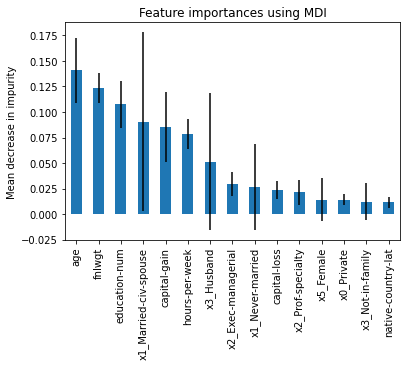

In [42]:
import matplotlib.pyplot as plt
rf_fs = RandomForestClassifier()
rf_fs.fit(X_fs_train,Y_fs_train)
importances = rf_fs.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_fs.estimators_], axis=0)

ix = np.argsort(importances)[::-1]
importances=importances[ix]
std=std[ix]
feature_names=feature_names_enc[ix]
si_ratios=[i/j for i,j in zip(std,importances)]
for i in range(len(importances)):
    
    print(feature_names[i],importances[i],"("+str(std[i])+")","S/I Ratio:",si_ratios[i])
    
import pandas as pd

#let's plot only the first 15 features to make the plot more visually appealing
forest_importances = pd.Series(importances[:15],index=feature_names_enc[ix[:15]])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std[:15], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()

2. Choosing the **top 6 features**, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.

In [43]:
features_to_select=list(range(6))
print(ix[features_to_select])

[ 0  1  2 17  3  5]


## Naive Bayes (6 Features)

In [44]:
X_fs_reduced = X_fs_test[:,ix[features_to_select]]
X_validation_proj_reduced = X_validation_proj[:,ix[features_to_select]]
gnb_fs6 = GaussianNB()
gnb_fs6.fit(X_fs_reduced,Y_fs_test)
gnb_fs6_y_pred=gnb_fs6.predict(X_validation_proj_reduced)
gnb_fs6_metrics = p1_metrics(Y_validation_proj, gnb_fs6_y_pred)
print("NB Validation Metrics")
for metric in gnb_fs6_metrics:
    print(metric+":",gnb_fs6_metrics[metric])

NB Validation Metrics
auc: 0.5958437185622862
f1: 0.3379701184956208
accuracy: 0.7662361287975259
sensitivity: 0.21678783873099802
specificity: 0.9748995983935743
precision: 0.7663551401869159
confusion_matrix: [[3884  100]
 [1185  328]]


## SVM (6 Features)

In [45]:
X_fs_reduced_scaled = X_fs_test_scaled[:,ix[features_to_select]]
X_validation_proj_reduced_scaled = X_validation_proj_scaled[:,ix[features_to_select]]
svmc_fs6 = SVC()
svmc_fs6.fit(X_fs_reduced_scaled,Y_fs_test)
svmc_fs6_y_pred=svmc_fs6.predict(X_validation_proj_reduced_scaled)
svmc_fs6_metrics= p1_metrics(Y_validation_proj, svmc_fs6_y_pred)
print("SVM Validation Metrics")
for metric in svmc_fs6_metrics:
    print(metric+":",svmc_fs6_metrics[metric])

SVM Validation Metrics
auc: 0.766552661405702
f1: 0.6737536656891495
accuracy: 0.8380935055484809
sensitivity: 0.6074025115664243
specificity: 0.9257028112449799
precision: 0.7563786008230453
confusion_matrix: [[3688  296]
 [ 594  919]]


## Random Forest (6 Features)

In [46]:
rf_fs6 = RandomForestClassifier()
rf_fs6.fit(X_fs_reduced,Y_fs_test)
rf_fs6_y_pred=rf_fs6.predict(X_validation_proj_reduced)
rf_fs6_metrics= p1_metrics(Y_validation_proj,rf_fs6_y_pred)
print("RF Validation Metrics")
for metric in rf_fs6_metrics:
    print(metric+":",rf_fs6_metrics[metric])

RF Validation Metrics
auc: 0.7685847487769982
f1: 0.6691884456671252
accuracy: 0.8249954520647625
sensitivity: 0.643093192333113
specificity: 0.8940763052208835
precision: 0.6974910394265234
confusion_matrix: [[3562  422]
 [ 540  973]]


3. Choosing the **top 11 features**, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.

In [47]:
features_to_select=list(range(11))
print(ix[features_to_select])

[ 0  1  2 17  3  5 37 25 19  4 31]


## Naive Bayes (11 Features)

In [48]:
X_fs_reduced = X_fs_test[:,ix[features_to_select]]
X_validation_proj_reduced = X_validation_proj[:,ix[features_to_select]]
gnb_fs11 = GaussianNB()
gnb_fs11.fit(X_fs_reduced,Y_fs_test)
gnb_fs11_y_pred=gnb_fs11.predict(X_validation_proj_reduced)
gnb_fs11_metrics = p1_metrics(Y_validation_proj, gnb_fs11_y_pred)
print("NB Validation Metrics")
for metric in gnb_fs11_metrics:
    print(metric+":",gnb_fs11_metrics[metric])

NB Validation Metrics
auc: 0.6243972087955258
f1: 0.4177449168207024
accuracy: 0.7707840640349282
sensitivity: 0.29874421678783875
specificity: 0.9500502008032129
precision: 0.6943164362519201
confusion_matrix: [[3785  199]
 [1061  452]]


## SVM (11 Features)

In [49]:
X_fs_reduced_scaled = X_fs_test_scaled[:,ix[features_to_select]]
X_validation_proj_reduced_scaled = X_validation_proj_scaled[:,ix[features_to_select]]
svmc_fs11 = SVC()
svmc_fs11.fit(X_fs_reduced_scaled,Y_fs_test)
svmc_fs11_y_pred=svmc_fs11.predict(X_validation_proj_reduced_scaled)
svmc_fs11_metrics= p1_metrics(Y_validation_proj, svmc_fs11_y_pred)
print("SVM Validation Metrics")
for metric in svmc_fs11_metrics:
    print(metric+":",svmc_fs11_metrics[metric])

SVM Validation Metrics
auc: 0.7779431506594786
f1: 0.688034188034188
accuracy: 0.8406403492814263
sensitivity: 0.6384666226040978
specificity: 0.9174196787148594
precision: 0.745945945945946
confusion_matrix: [[3655  329]
 [ 547  966]]


## Random Forest (11 Features)

In [50]:
rf_fs11 = RandomForestClassifier()
rf_fs11.fit(X_fs_reduced,Y_fs_test)
rf_fs11_y_pred=rf_fs11.predict(X_validation_proj_reduced)
rf_fs11_metrics= p1_metrics(Y_validation_proj,rf_fs11_y_pred)
print("RF Validation Metrics")
for metric in rf_fs11_metrics:
    print(metric+":",rf_fs11_metrics[metric])

RF Validation Metrics
auc: 0.7846944619190575
f1: 0.6946273830155979
accuracy: 0.8397307622339458
sensitivity: 0.6622604097818903
specificity: 0.9071285140562249
precision: 0.7303206997084548
confusion_matrix: [[3614  370]
 [ 511 1002]]


4. Compare the performance of the models with respect the algorithm used (e.g., NB) and the number of features chosen (6, 11, and all features (those constructed in Part 1). How do they compare?

In [51]:
print("Model\t\t6\t\t\t11\t\t\t52")
print("NB\t"+str(gnb_fs6_metrics['auc'])+"\t"+str(gnb_fs11_metrics['auc'])+"\t"+str(gnb_metrics['auc']))
print("SVM\t"+str(svmc_fs6_metrics['auc'])+"\t"+str(svmc_fs11_metrics['auc'])+"\t"+str(svmc_metrics['auc']))
print("RF\t"+str(rf_fs6_metrics['auc'])+"\t"+str(rf_fs11_metrics['auc'])+"\t"+str(rf_metrics['auc']))

Model		6			11			52
NB	0.5958437185622862	0.6243972087955258	0.6251502208437185
SVM	0.766552661405702	0.7779431506594786	0.7773074286571269
RF	0.7685847487769982	0.7846944619190575	0.7996872652540101


Feature selection does not improve model performance. However, the models achieve nearly the same performance using the top 11 features as when all features are used.

## Part 6: Final Models and Visualization

1. Using the full training set (**feature selection + training + validation**), train NB, SVM, and RF models, then apply them to the test set. Your final NB, SVM, and RF models should be named `gnb_final`, `svm_final`, and `rf_final`.
2. Create a bar chart of mean metrics from cross-validation, with standard deviation as an error bar for each model on the same plot. Use the NB model from Part 2, but the optimal models from Parts 3 and 4 for SVM and RF respectively.
3. Plot Receiver Operating Characteristic (ROC) curves for each final model in a single plot.
4. Which of the above metrics best illuminate the difference (if any) in model performance? Why?

1. Using the full training set (**feature selection + training + validation**), train NB, SVM, and RF models, then apply them to the test set. Your final NB, SVM, and RF models should be named `gnb_final`, `svm_final`, and `rf_final`.

## Final Naive Bayes

In [52]:
gnb_final = GaussianNB()
gnb_final.fit(X_train_proj_full,Y_train_proj_full)
gnb_final_y_pred=gnb_final.predict(X_test_proj)
gnb_final_metrics = p1_metrics(Y_test_proj, gnb_final_y_pred)
print("NB Final Metrics")
for metric in gnb_final_metrics:
    print(metric+":",gnb_final_metrics[metric])

NB Final Metrics
auc: 0.628676332802787
f1: 0.4305493523894595
accuracy: 0.7680553028924868
sensitivity: 0.31836195508586523
specificity: 0.9389907105197087
precision: 0.6648275862068965
confusion_matrix: [[3740  243]
 [1032  482]]


## Final SVM

In [53]:
svm_final = SVC(C=10,kernel='rbf',gamma='auto')
svm_final.fit(X_train_proj_full_scaled,Y_train_proj_full)
svm_final_y_pred=svm_final.predict(X_test_proj_scaled)
svm_final_metrics= p1_metrics(Y_test_proj, svm_final_y_pred)
print("SVM Final Metrics")
for metric in svm_final_metrics:
    print(metric+":",svm_final_metrics[metric])

SVM Final Metrics
auc: 0.7930390089186838
f1: 0.7091800981079188
accuracy: 0.8490085501182463
sensitivity: 0.6684280052840158
specificity: 0.9176500125533518
precision: 0.755223880597015
confusion_matrix: [[3655  328]
 [ 502 1012]]


## Final Random Forest

In [54]:
rf_final = RandomForestClassifier()
rf_final.fit(X_train_proj_full,Y_train_proj_full)
rf_final_y_pred=rf_final.predict(X_test_proj)
rf_final_metrics= p1_metrics(Y_test_proj,rf_final_y_pred)
print("RF Training Metrics")
for metric in rf_final_metrics:
    print(metric+":",rf_final_metrics[metric])

RF Training Metrics
auc: 0.800094009182354
f1: 0.7205623901581721
accuracy: 0.8553756594506094
sensitivity: 0.6770145310435931
specificity: 0.9231734873211147
precision: 0.7700976709241172
confusion_matrix: [[3677  306]
 [ 489 1025]]


2. Create a bar chart of mean metrics from cross-validation, with standard deviation as an error bar for each model on the same plot. Use the NB model from Part 2, but the optimal models from Parts 3 and 4 for SVM and RF respectively.

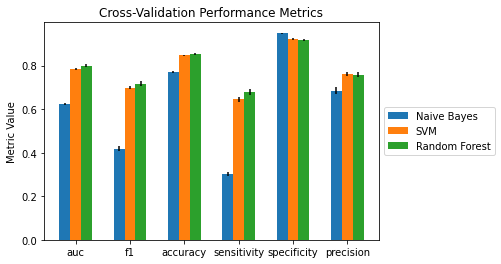

In [55]:
labels=metric_keys
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

gnb_mean_metrics = [gnb_cv_stats["test_"+l+"_mean"] for l in labels]
gnb_std_metrics = [gnb_cv_stats["test_"+l+"_std"] for l in labels]
svm_mean_metrics = [svm_cv_stats["test_"+l+"_mean"] for l in labels]
svm_std_metrics = [svm_cv_stats["test_"+l+"_std"] for l in labels]
rf_mean_metrics = [rf_cv_stats["test_"+l+"_mean"] for l in labels]
rf_std_metrics = [rf_cv_stats["test_"+l+"_std"] for l in labels]

fig, ax = plt.subplots()
gnb_results = ax.bar(x - width, gnb_mean_metrics, width,yerr=gnb_std_metrics, label='Naive Bayes')
svm_results = ax.bar(x, svm_mean_metrics, width, yerr=svm_std_metrics, label='SVM')
rf_results = ax.bar(x + width, rf_mean_metrics, width, yerr=rf_std_metrics, label='Random Forest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Value')
ax.set_title('Cross-Validation Performance Metrics')
plt.xticks(ticks=x,labels=labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


#fig.tight_layout()

plt.show()

3. Plot Receiver Operating Characteristic (ROC) curves for each final model in a single plot.

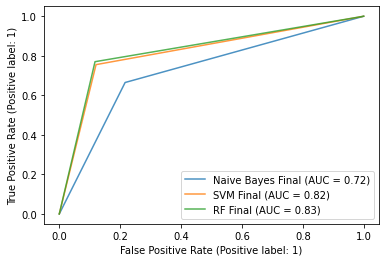

In [56]:
from sklearn.metrics import RocCurveDisplay

ax = plt.gca()
roc_gnb = RocCurveDisplay.from_predictions(gnb_final_y_pred, Y_test_proj, ax=ax, alpha=0.8,name="Naive Bayes Final")
roc_svm = RocCurveDisplay.from_predictions(svm_final_y_pred, Y_test_proj, ax=ax, alpha=0.8,name="SVM Final")
roc_rf = RocCurveDisplay.from_predictions(rf_final_y_pred,Y_test_proj, ax=ax, alpha=0.8,name="RF Final")
plt.show()

4. Which of the above metrics best illuminate the difference (if any) in model performance? Why?

The poor performance of the Naive Bayes model relative to the other models is best observed by looking at the sensitivity values. As mentioned above, the Naive Bayes model performs poorly on the '>50K' class, which is also why the F1 score is lower for that model. The Random Forest model outperforms the SVM model slightly in sensitivity and roughly equivalently in specificity and precision, this makes the Random Forest model have slightly higher AUC and F1 scores.

## Part 7: Holdout Set Evaluation (Instructor)

Your final models `gnb_final`, `svm_final`, and `rf_final` will be evaluated on a holdout set by the instructor.

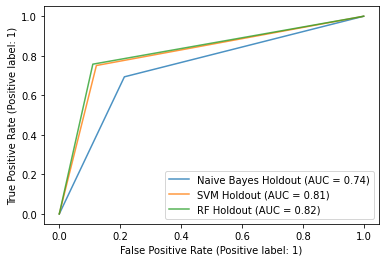

In [57]:
from sklearn.metrics import RocCurveDisplay
census_column_names=['age','workclass','fnlwgt','education','education-num',
                      'marital-status','occupation','relationship','race','sex',
                      'capital-gain','capital-loss','hours-per-week','native-country',
                      'annual-income']

census_holdout_data = pd.read_csv("census_dataset_holdout.csv",names=census_column_names)
census_holdout_data.drop('education',axis=1,inplace=True)
census_column_names.remove('education')

#split features and labels, convert X sets to numpy to enable inverse transform
X_holdout_data = census_holdout_data.drop('annual-income',axis=1)
X_holdout_data = X_holdout_data.to_numpy()
Y_holdout_data = census_holdout_data[['annual-income']]
Y_holdout_data = Y_holdout_data.to_numpy()

X_holdout_country_enc=CountryEncoder.transform(X_holdout_data[:,country_index])
np.delete(X_holdout_data,country_index,axis=1)
X_holdout_oh_enc=oh_encoder.transform(X_holdout_data[:,census_cat_indices])
X_holdout_data_enc=np.concatenate([X_holdout_data[:,census_num_columns_idx],
                           X_holdout_oh_enc,
                           X_holdout_country_enc],
                          axis=1)
Y_holdout_data_enc = label_encoder.transform(Y_holdout_data)
X_holdout_data_scaled=svm_scaler.transform(X_holdout_data_enc)
ax = plt.gca()
roc_gnb = RocCurveDisplay.from_predictions(gnb_final.predict(X_holdout_data_enc), Y_holdout_data_enc, ax=ax, alpha=0.8,name="Naive Bayes Holdout")
roc_svm = RocCurveDisplay.from_predictions(svm_final.predict(X_holdout_data_scaled), Y_holdout_data_enc, ax=ax, alpha=0.8,name="SVM Holdout")
roc_rf = RocCurveDisplay.from_predictions(rf_final.predict(X_holdout_data_enc),Y_holdout_data_enc, ax=ax, alpha=0.8,name="RF Holdout")
plt.show()